# ML vs Marcel Projections Analysis

This notebook compares the performance of our new **XGBoost ML Model** against the baseline **Marcel Projection System**.

## Models Compared
1. **Marcel**: Weighted average of past 3 years + regression to mean + aging curve.
2. **XGBoost**: Gradient boosting regressor trained on 2023-2024 data (IPL only) with lagged features.

## Target
Predicting **IPL 2025 WAR**.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from IPython.display import Image, display

# Paths
PROJECT_ROOT = Path('..')
MARCEL_DIR = PROJECT_ROOT / 'results' / '13_projections' / 'backtest_2025'
ML_DIR = PROJECT_ROOT / 'results' / '15_ml_projections'
ACTUAL_DIR = PROJECT_ROOT / 'results' / '09_vorp_war'

def load_comparison_data(role='batter'):
    # Load Marcel
    marcel = pd.read_csv(MARCEL_DIR / f'{role}_projections_2025.csv')
    marcel = marcel.rename(columns={f'{role}_name': 'player_name', 'projected_war_2025': 'marcel_war'})
    
    # Load ML
    ml = pd.read_csv(ML_DIR / f'{role}_backtest_2025.csv')
    ml = ml.rename(columns={f'{role}_name': 'player_name', 'predicted_war': 'ml_war'})
    
    # Load Actuals
    actual = pd.read_csv(ACTUAL_DIR / f'{role}_war.csv')
    actual = actual[actual['season'] == 2025].rename(columns={f'{role}_name': 'player_name', 'WAR': 'actual_war'})
    
    # Merge
    merged = marcel[['player_name', 'marcel_war']].merge(
        ml[['player_name', 'ml_war']], on='player_name', how='inner'
    ).merge(
        actual[['player_name', 'actual_war']], on='player_name', how='inner'
    )
    
    return merged

bat_df = load_comparison_data('batter')
bowl_df = load_comparison_data('bowler')

print(f"Batters: {len(bat_df)}")
print(f"Bowlers: {len(bowl_df)}")

Batters: 138
Bowlers: 108


## Batting Comparison

In [2]:
def print_metrics(df, role):
    print(f"--- {role.upper()} METRICS ---")
    for model in ['marcel', 'ml']:
        mae = mean_absolute_error(df['actual_war'], df[f'{model}_war'])
        rmse = np.sqrt(mean_squared_error(df['actual_war'], df[f'{model}_war']))
        r2 = r2_score(df['actual_war'], df[f'{model}_war'])
        print(f"{model.capitalize()}: MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")

print_metrics(bat_df, 'Batting')

--- BATTING METRICS ---
Marcel: MAE=0.143, RMSE=0.214, R2=0.280
Ml: MAE=0.223, RMSE=0.309, R2=-0.503


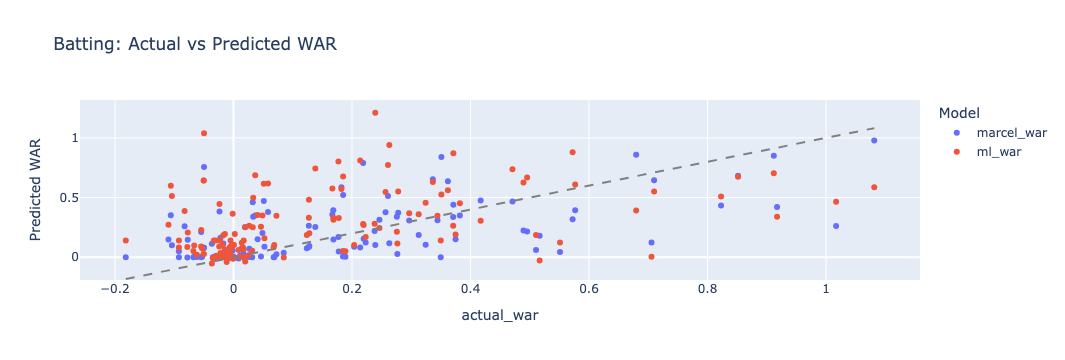

In [3]:
fig = px.scatter(bat_df, x='actual_war', y=['marcel_war', 'ml_war'], 
                 hover_data=['player_name'],
                 title='Batting: Actual vs Predicted WAR',
                 labels={'value': 'Predicted WAR', 'variable': 'Model'})
fig.add_shape(type='line', x0=bat_df['actual_war'].min(), y0=bat_df['actual_war'].min(),
              x1=bat_df['actual_war'].max(), y1=bat_df['actual_war'].max(),
              line=dict(color='gray', dash='dash'))
fig.show()

## Bowling Comparison

In [4]:
print_metrics(bowl_df, 'Bowling')

--- BOWLING METRICS ---
Marcel: MAE=0.215, RMSE=0.298, R2=0.202
Ml: MAE=0.279, RMSE=0.403, R2=-0.461


In [5]:
fig = px.scatter(bowl_df, x='actual_war', y=['marcel_war', 'ml_war'], 
                 hover_data=['player_name'],
                 title='Bowling: Actual vs Predicted WAR',
                 labels={'value': 'Predicted WAR', 'variable': 'Model'})
fig.add_shape(type='line', x0=bowl_df['actual_war'].min(), y0=bowl_df['actual_war'].min(),
              x1=bowl_df['actual_war'].max(), y1=bowl_df['actual_war'].max(),
              line=dict(color='gray', dash='dash'))
fig.show()

## Feature Importance (SHAP)
What features drove the ML model's predictions?

Batting Feature Importance:


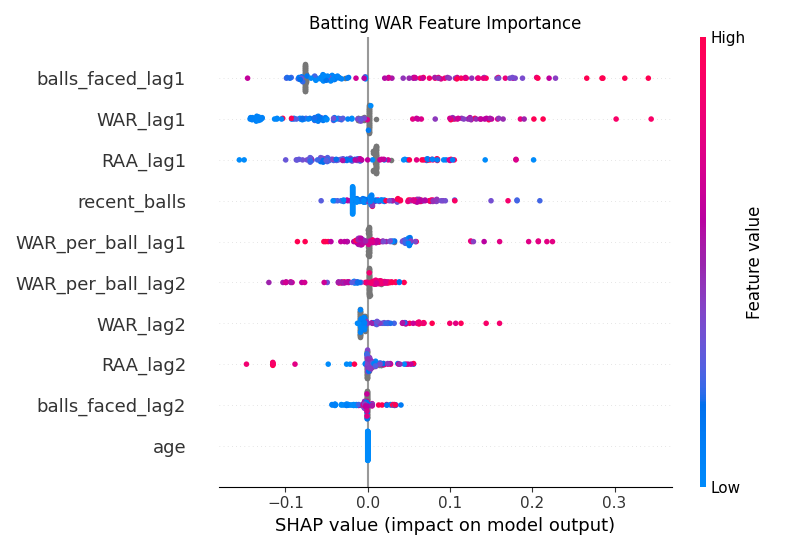

Bowling Feature Importance:


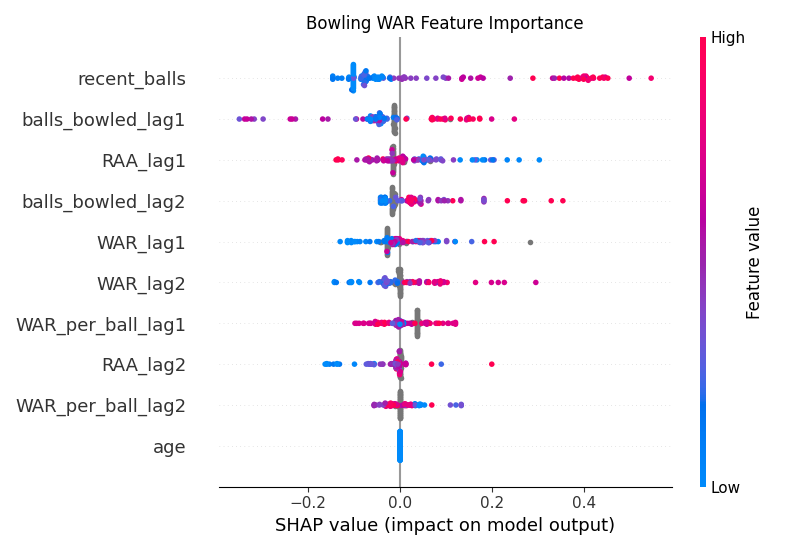

In [6]:
print("Batting Feature Importance:")
display(Image(filename=str(ML_DIR / 'shap_batting.png')))

print("Bowling Feature Importance:")
display(Image(filename=str(ML_DIR / 'shap_bowling.png')))